# Micrograd

Credit: https://www.youtube.com/watch?v=VMj-3S1tku0

In [97]:
import math
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

## Create data

In [98]:
def f(x):
    return 3*x**2 - 4*x + 5

In [99]:
f(3.0)

20.0

In [100]:
# Define a 1d array of values
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [101]:
# create a new 1d array of values, based on f(x)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

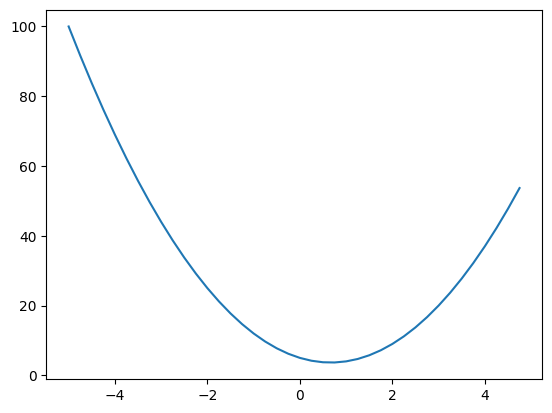

In [102]:
plt.plot(xs, ys)

## Differentiation

### Simple case

In [103]:
h = 0.001
x = 3.0

f_x = f(x)
f_xh = f(x+h)
print(f_x)
print(f_xh)

# rise over run -> slope
# if we manually differentiate f(x) for f = 3 
# dx =  6x - 4 + 0 -> 6 * 3 - 4 = 14
print((f_xh - f_x) / h)

20.0
20.014003000000002
14.00300000000243


### More complex function

In [104]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [105]:
h = 0.001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)

print(f'slope: {(d2 - d1) / h}')

d1 4.0
d2 3.997
slope: -3.0000000000001137


### Classes

In [106]:
class Value:
    """
        'out' refers to the incoming gradient in backprop; i.e. node to the right 
    """
    def __init__(self, data, _children: tuple = (), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0.0


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            # d = 1 - tanh(x)**2
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out


    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out


    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()


    def __repr__(self):
        return f'Value(data={self.data})'
    
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        # For an '+', we just take the incoming grad
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supported int/float powers'
        out = Value(self.data ** other, (self,), f'**{other}')        

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward

        return out

    # handles self / other
    def __truediv__(self, other):
        return self * other**-1


    def __neg__(self): # -self
        return self * -1


    def __sub__(self, other): # self - other
        return self + (-other)
    

    # handle cases such as '2 * Value(3.0)'
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other

In [107]:
a = Value(2.0, label='a')
a

Value(data=2.0)

In [108]:
b = Value(-3.0, label='b')
b

Value(data=-3.0)

In [109]:
a + b

Value(data=-1.0)

In [110]:
a * b

Value(data=-6.0)

In [111]:
c = Value(10.0, label='c')

In [112]:
d = a*b + c # 2 * -3 + 10 = +4
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [113]:
d

Value(data=4.0)

In [114]:
d._op

'+'

In [115]:
e = a*b
e.label = 'e'
d = e+c
d.label = 'd'

In [116]:
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

Value(data=-8.0)

In [117]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

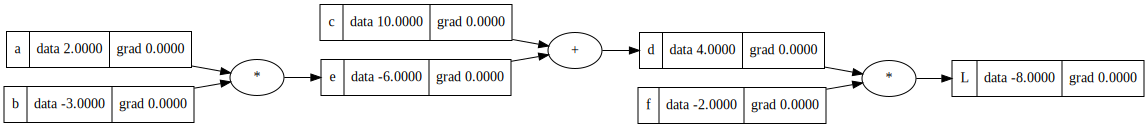

In [118]:
draw_dot(L)

In [119]:
L.grad = 1.0

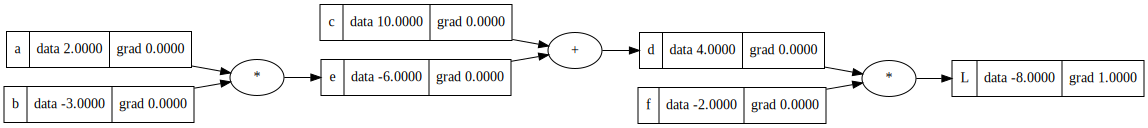

In [120]:
draw_dot(L)

In [121]:
#dL/dd = f
d.grad = -2.0

#dL/df = d
f.grad = 4.0

In [122]:
# dL / dc
# dL / dc = dL/dd * dd/dc = dL/dd * 1 = dL/dd
c.grad = d.grad
# dL / de = dL/dd * dd/de = dL/dd * 1 = dL/dd
e.grad = d.grad

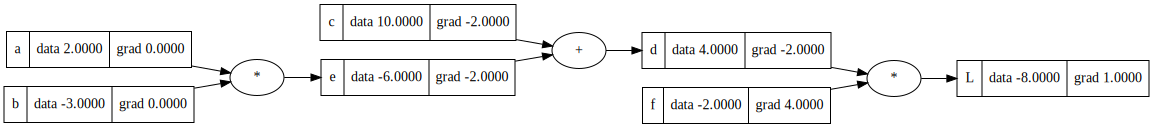

In [123]:
draw_dot(L)

In [124]:
# dL / db = dL/de * de/ db = dL / de * a
b.grad = -2.0 * 2.0

# dL / da = dL/de * de/ da = dL / de * b
a.grad = -2.0 * -3.0

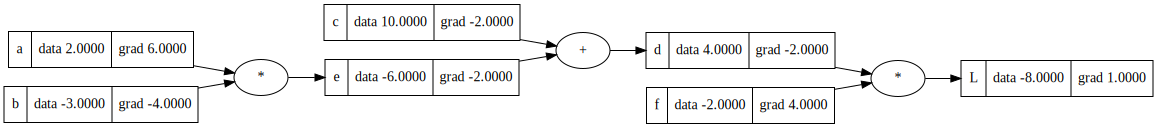

In [125]:
draw_dot(L)

### Activation Function

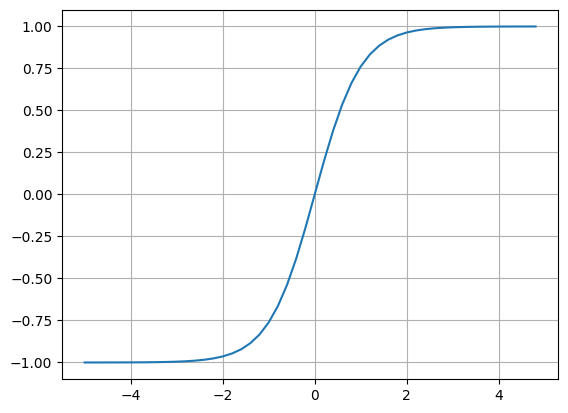

In [126]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [127]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2;
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'

In [128]:
o.grad = 1.0

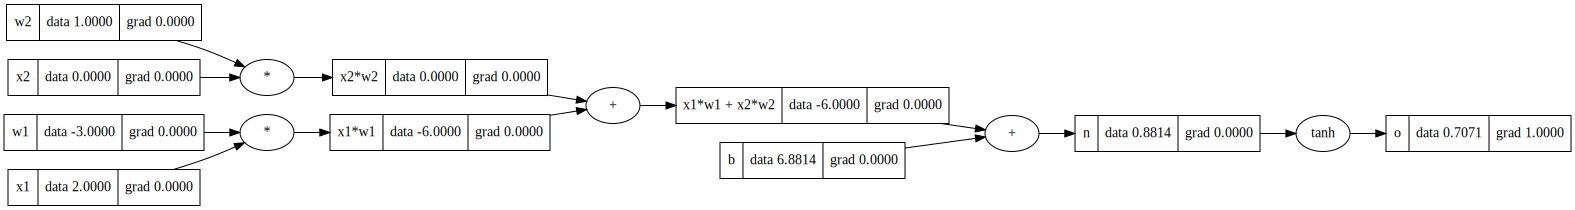

In [129]:
draw_dot(o)

In [130]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2 
1 - o.data**2

0.4999999999999999

In [131]:
n.grad = 0.5

In [132]:
# from n to the left -> x1w1x2w2 and b are connected to 'n' with a '+'
# their local derivatives is the same as n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [133]:
# same argument as above.
x1w1.grad = 0.5
x2w2.grad = 0.5

In [134]:
# d_x2w2/d_x2 = w2 = 1.0
# d_o/d_x2 = do/d_x2w2 * d_x2w2/d_x2 = x2w2.grad * 1.0 = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

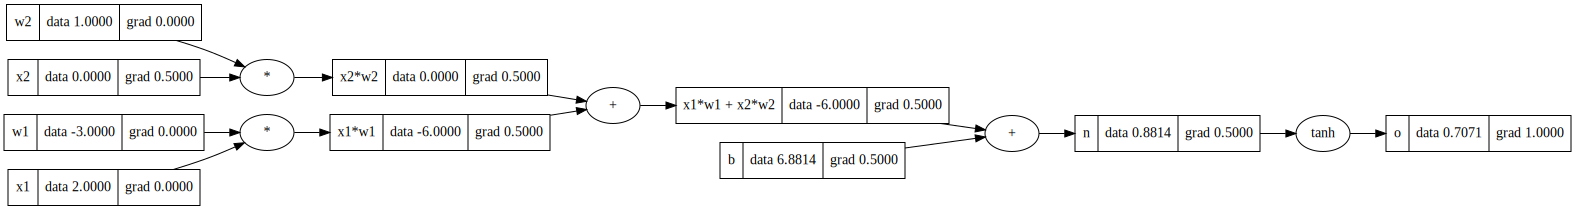

In [135]:
draw_dot(o)

In [136]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

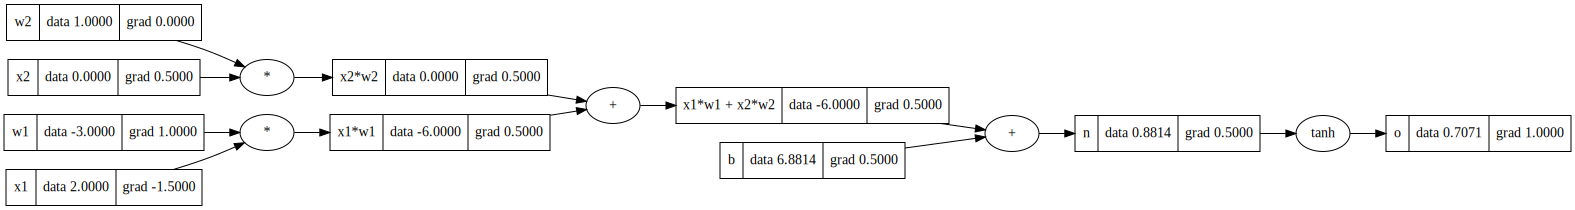

In [137]:
draw_dot(o)

In [138]:
o.grad = 1.0
o._backward()

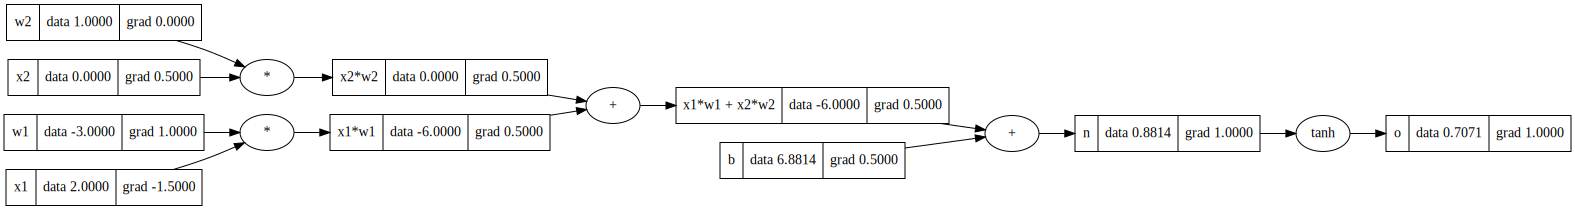

In [139]:
draw_dot(o)

In [140]:
n._backward()

In [141]:
# leaf node -> no impact
b._backward()

In [142]:
x1w1x2w2._backward()

In [143]:
x2w2._backward()

In [144]:
x1w1._backward()

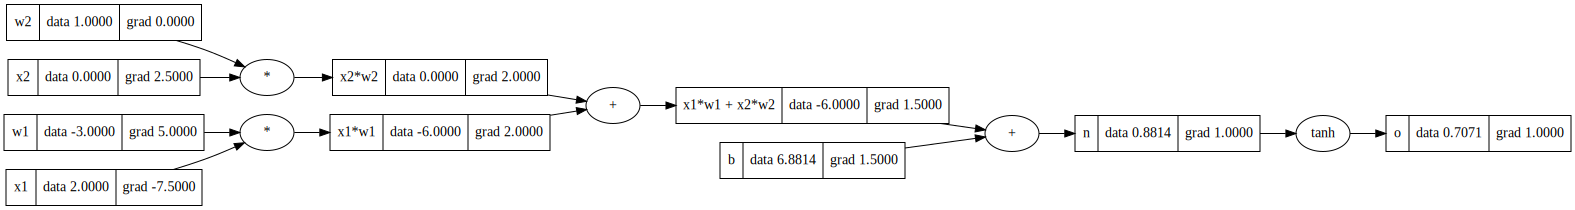

In [145]:
draw_dot(o)

In [146]:
topo = []
visited = set()

def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

### Using automatic differentiation

In [147]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2;
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'

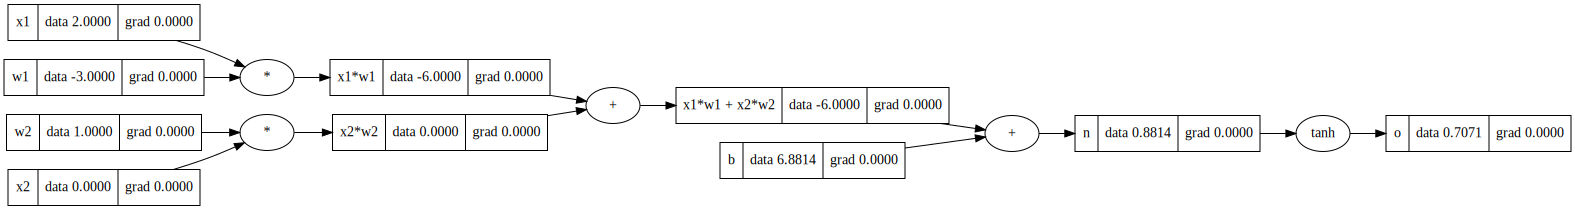

In [148]:
draw_dot(o)

In [149]:
o.backward()

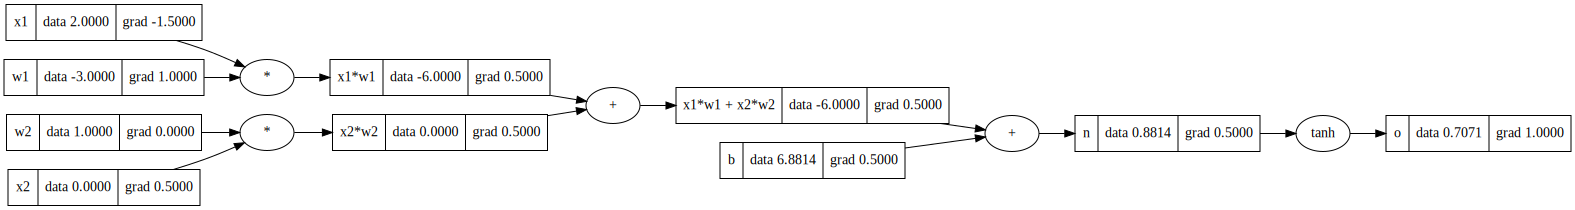

In [150]:
draw_dot(o)

### Breakup the tanh into atomical components

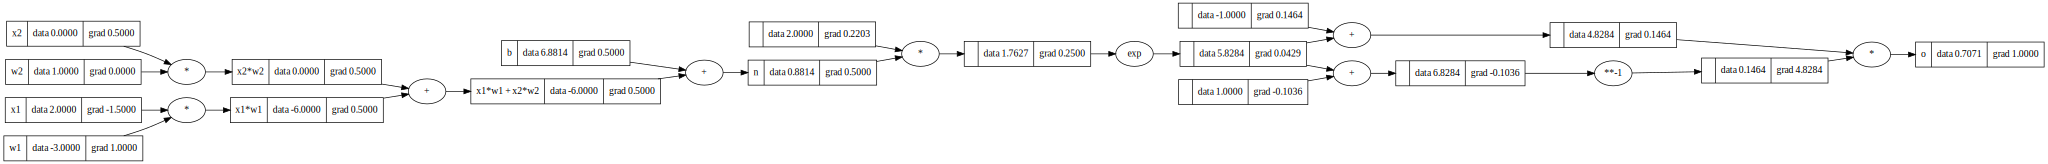

In [151]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2;
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e+1)
o.label = 'o'
o.backward()
draw_dot(o)

## Using PyTorch

In [152]:
import torch
import random

In [153]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Quick explanation about the zip function in python

In [154]:
nin = 5
w = [Value(random.uniform(-1,1)) for _ in range(nin)]
b = Value(random.uniform(-1,1))
x = [2.0, 3.0]

# zip takes 2 iterators and creates tuples with the individual elements of each iterator contained in each tuple.
print(list(zip(w, x)))

[(Value(data=0.2819023315600786), 2.0), (Value(data=-0.17100147294584267), 3.0)]


In [155]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        # w * x + b
        # element-wise multiplication of the w's with the x's, then add the b's
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out
    
    def parameters(self):
        # concatenate 2 lists, where [self.b] is the second one
        return self.w + [self.b]

In [156]:
n = Neuron(2)
n(x)

Value(data=-0.8744608600837552)

In [157]:
class Layer:
  # nin is the number of weight per neuron
  # nout is the size of the layer, i.e. how many neurons
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [158]:
n = Layer(2, 3)
n(x)

[Value(data=0.9446447605056301),
 Value(data=-0.7598950454852201),
 Value(data=0.9619063176225944)]

In [159]:
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [160]:
# three inputs
x = [2.0, 3.0, -1.0]

# MLP with three inputs, one layer with 4 neurons, one layer with 4 neurons, and finally one layer with 1 neuron
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.38778033650216753)

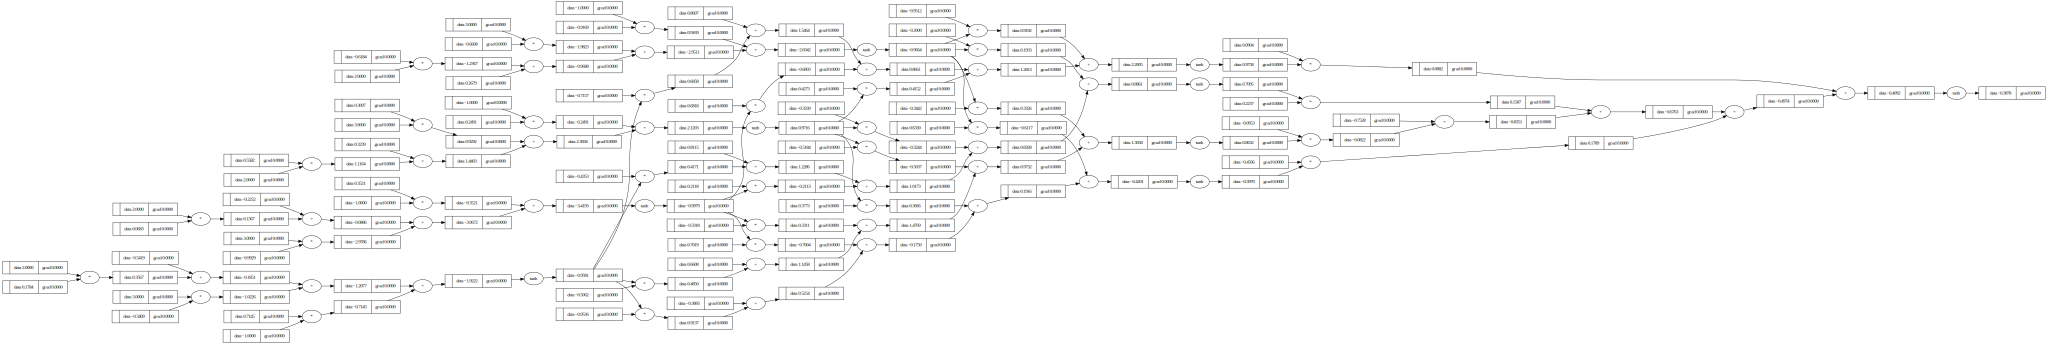

In [161]:
draw_dot(n(x))

### Train a simple model

In [162]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.38778033650216753),
 Value(data=-0.29105963491860937),
 Value(data=-0.2500770862297551),
 Value(data=-0.5534680134810709)]

In [163]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.4041779491302835)

In [164]:
loss.backward()

In [165]:
# we can inspect gradients of individual weights, of individual neurons, for each layer
n.layers[0].neurons[0].w[0].grad

0.4955553393337912

In [166]:
len(n.parameters())

41

In [167]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 5.4041779491302835
1 3.6812182758239134
2 3.5391343108239868
3 3.4306272631961123
4 2.3659346438464723
5 2.406416845566594
6 0.6726702897613774
7 0.32260054912909325
8 0.07578548566068229
9 0.06458176382811716
10 0.056192588989998446
11 0.049658998962004396
12 0.04442863248404676
13 0.04015100180755263
14 0.03659103146949526
15 0.03358479110178314
16 0.03101443332015088
17 0.028793090325942655
18 0.026855354962457827
19 0.025151066387048143


In [168]:
ypred

[Value(data=0.9111012576907312),
 Value(data=-0.9733214366588124),
 Value(data=-0.8940520898464847),
 Value(data=0.9271208219377355)]